In [1]:
import os
import pickle5 as pickle
import scanpy as sc 
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LogisticRegressionCV


In [2]:
data_file_list=os.listdir('/home/iGTP/iGTP_data')
data_file_list=[i for i in data_file_list if '.h5ad' in i]
data_file_list.sort()                     

In [3]:
print(data_file_list[13])

pbmc_IFN_filtered.h5ad


In [4]:
data=sc.read('/home/iGTP/iGTP_data/'+data_file_list[13])
origin_data=data.X.A
cell_inf=data.obs.copy()

In [5]:
sc_pathway_data=sc.read('/home/iGTP/iGTP_data/PBMC_cell_score/pbmc_IFN_GO_non_redundant_object.h5ad')
sc_pathway_data=sc_pathway_data.X.A

In [6]:
vega_data_path='/home/iGTP/fig_2_result/z_embedding/whole_z/GO_merged_7000fold_0_pbmc_ifn_z_vega.pkl'
igtp_data_path='./fig_2_result/z_embedding/whole_z/GO_merged_PC_homo_v11mse_pos_uniform_15000batch_pbmc_ifn_z.pkl'
igtp_ppi_path='./fig_2_result/z_embedding/Z_PPI/GO_merged_PC_homo_v11mse_pos_uniform_15000batch_pbmc_ifn_z.pkl'

In [8]:
with open(vega_data_path, 'rb') as file:
    vega_data=pickle.load(file)

with open(igtp_data_path, 'rb') as file:
    igtp_data=pickle.load(file)

with open(igtp_ppi_path, 'rb') as file:
    igtp_ppi_data=pickle.load(file)

In [9]:
file_list=[origin_data,sc_pathway_data,vega_data,igtp_data,igtp_ppi_data]
file_list_1=['gene','ssgesa','Vega','iGTP','iGTP_PPI']

In [10]:
cell_inf['label']=np.where(cell_inf['stim']=='ctrl',0,1)
cell_inf['cell_index']=range(len(cell_inf))

In [11]:
train_index,test_index,train_label,test_label=train_test_split(cell_inf['cell_index'].values, cell_inf['label'].values, test_size=0.2,stratify=cell_inf['label'], random_state=42)

In [12]:
all_df=pd.DataFrame()
for i in tqdm(range(len(file_list))):
    data=file_list[i]
    data_name=file_list_1[i]
    train_data=data[train_index,]
    test_data=data[test_index,]
    clf = xgb.XGBClassifier()
    clf.fit(train_data, train_label)
    y_prob = clf.predict_proba(test_data)[:, 1]
    fpr, tpr, thresholds = roc_curve(test_label, y_prob)
    roc_auc = auc(fpr, tpr)
    print(data_name, '| AUC: %.3f |' % (roc_auc), flush=True)
    temp_df=pd.DataFrame(test_label,columns=['class'])
    temp_df['predict_prob']=y_prob
    temp_df['data_set']=data_name
    all_df=pd.concat([all_df,temp_df])

  0%|                                                                                                                         | 0/5 [00:00<?, ?it/s]

gene | AUC: 0.988 |


 20%|██████████████████████▍                                                                                         | 1/5 [11:10<44:42, 670.56s/it]

ssgesa | AUC: 0.988 |


 40%|████████████████████████████████████████████▊                                                                   | 2/5 [11:28<14:20, 286.88s/it]

Vega | AUC: 0.988 |


 60%|███████████████████████████████████████████████████████████████████▏                                            | 3/5 [11:55<05:35, 167.87s/it]

iGTP | AUC: 0.990 |


 80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 4/5 [12:20<01:51, 111.52s/it]

iGTP_PPI | AUC: 0.987 |


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [20:04<00:00, 240.84s/it]


In [13]:
color_list = ['gold','royalblue', 'salmon','seagreen','black']

In [14]:
import matplotlib.pyplot as plt

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 83.49it/s]


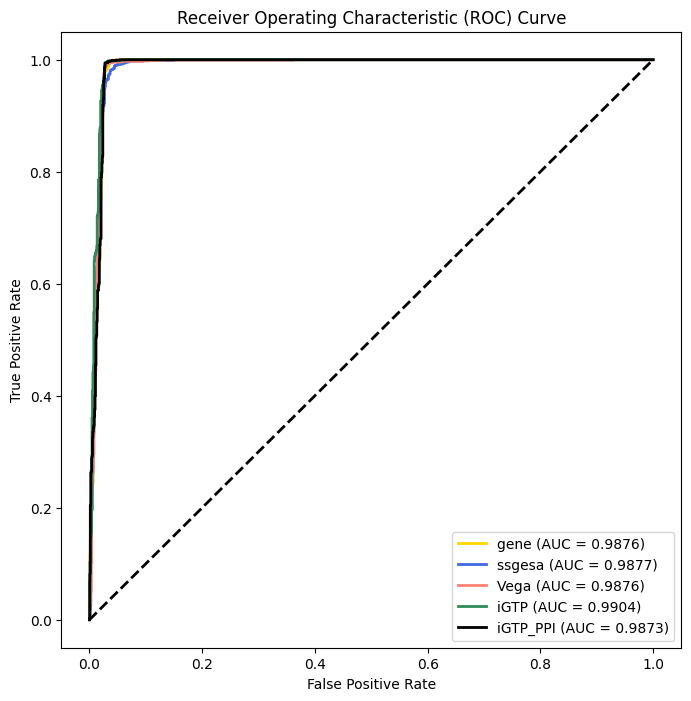

In [16]:
plt.figure(figsize=(8, 8))
for i in tqdm(range(len(file_list))):
    temp_df=all_df[all_df.data_set==file_list_1[i]]
    color=color_list[i]
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(temp_df['class'].values, temp_df['predict_prob'].values)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each classifier
    plt.plot(fpr, tpr, lw=2, label=f'{file_list_1[i]} (AUC = {roc_auc:.4f})', color=color)


# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
file_name='./fig_6_result/model_auc_compare.pdf'
plt.savefig(file_name, format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [17]:
file_list=os.listdir('./save_model/pbmc_IFN_filtered/processed_data')
file_list=[i for i in file_list if '.ipynb_checkpoints' not in i]
file_list=[i for i in file_list if 'GO' in i]
file_list=[i for i in file_list if 'mse' in i]
file_list=[i for i in file_list if 'batch' in i]
file_list.sort()

In [48]:
task_file_path='./save_model/pbmc_IFN_filtered/processed_data/'+file_list[0]
with open(task_file_path, 'rb') as file:
    task_file = pickle.load(file)
args=task_file['args']
data_x_s=task_file['data_x_s']
mask_list_dict=task_file['mask_dict']
data=task_file['data']
TP_df=task_file['TP_df']
PPI_df=task_file['ppi_df_1']
seq_gene_df=task_file['seq_gene_df']

In [19]:
igtp_data_path_2='./fig_2_result/z_embedding/whole_z/GO_merged_PC_homo_v11mse_pos_uniform_15000batch_pbmc_ifn_z.pkl'

In [33]:
TP_df

,TP_name,TP_gene,TP_index
0,BP_mitochondrial_genome_maintenance,"[MPV17, PIF1, SLC25A36, DNAJA3, ATG7, STOML2, ...",0
1,BP_transition_metal_ion_transport,"[FKBP4, ATP13A1, ATP6V1A, COX17, SLC39A1, SLC3...",1
2,BP_cell_cycle_checkpoint,"[MDM4, UIMC1, CDC14B, MUS81, CLSPN, TTK, GIGYF...",2
3,BP_protein_polyubiquitination,"[FBXL3, HERC6, UBE2E1, RNF111, FBXW4, PARP10, ...",3
4,BP_non_recombinational_repair,"[PRPF19, USP51, UIMC1, BARD1, POLA1, XRCC6, DT...",4
...,...,...,...
1291,MF_organic_hydroxy_compound_transmembrane_tran...,"[CEACAM1, ABCG1, ABCC3, SLC16A1, SLC18A1, MFSD...",1291
1292,MF_sulfur_compound_binding,"[HSD17B12, CXCL6, GSTM3, DPYSL3, ACOT7, CRISPL...",1292
1293,MF_sulfur_compound_transmembrane_transporter_a...,"[CTNS, SLC25A19, SLC26A4, SLC38A7, SLC26A6, SL...",1293
1294,MF_protein_tyrosine_kinase_binding,"[CD4, TRAT1, CD247, MAP3K7, FNTA, DOK2, DUSP3,...",1294


In [32]:
igtp_data_2.shape

(13672, 1296)

In [20]:
with open(igtp_data_path_2, 'rb') as file:
    igtp_data_2=pickle.load(file)

In [21]:
cell_inf=data.obs.copy()
cell_inf['cell_index']=range(len(cell_inf))

In [22]:
cell_inf['label']=np.where(cell_inf['stim']=='ctrl',0,1)

In [23]:
TP_df['TP_index']=range(len(TP_df))

In [25]:
import matplotlib.pyplot as plt
import shap

100%|===================| 13668/13672 [16:14<00:00]        

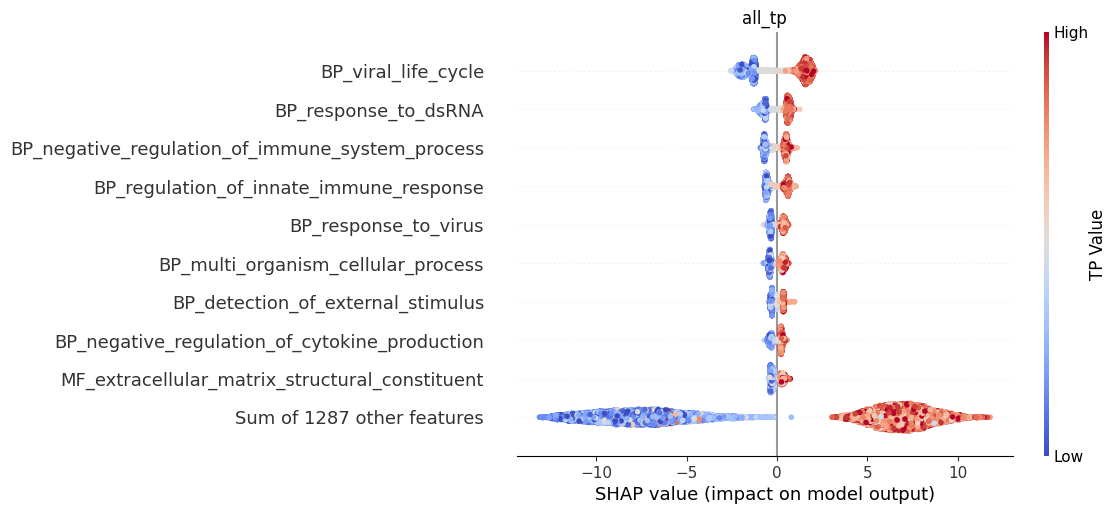

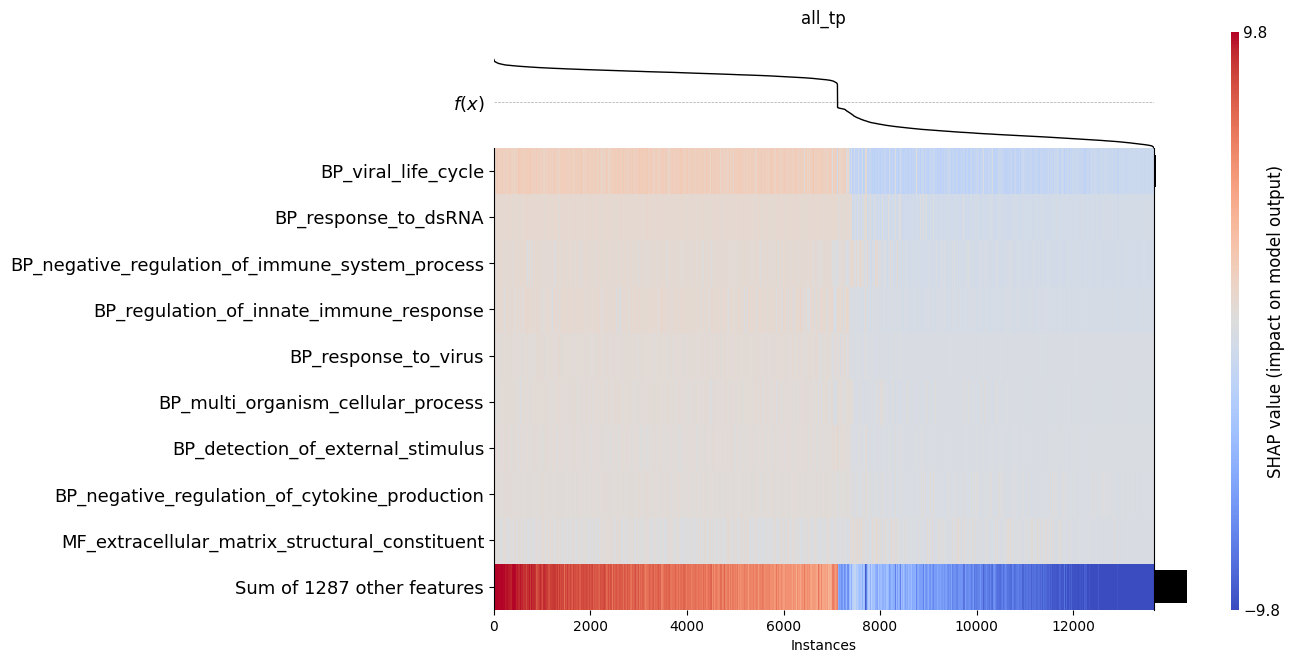

In [41]:
temp_x=pd.DataFrame(igtp_data_2,columns=TP_df['TP_name'].values)
temp_y=cell_inf.label.values
temp_x_path='./fig_6_result/TP_PPI_df/'+args['model_prefix']+'_all_tp.csv'
temp_x.to_csv(temp_x_path,index=False)
model = xgb.XGBClassifier(max_depth=5,
learning_rate=0.05,
n_estimators=3000)
model.fit(temp_x, temp_y)
#model = LogisticRegressionCV(cv=5,max_iter=500, random_state=0).fit(temp_x, temp_y)
explainer = shap.Explainer(model, temp_x)
shap_values = explainer(temp_x)
shap_df=pd.DataFrame(shap_values.values,columns=shap_values.feature_names)
shap_df_path='./fig_6_result/TP_PPI_df/'+args['model_prefix']+'_all_tp_shap.csv'
shap_df.to_csv(shap_df_path,index=False)
        
fig = plt.figure()  
shap.plots.beeswarm(shap_values,show=False,max_display=10,color_bar_label='TP Value', color=plt.get_cmap("coolwarm"))
shap_plot_path='./fig_6_result/TP_PPI_figure_bee/'+args['model_prefix']+'_all_tp.pdf'
plt.title('all_tp')
plt.savefig(shap_plot_path,format='pdf',dpi=300,bbox_inches='tight')
        #plt.close()
        
fig = plt.figure()
shap.plots.heatmap(shap_values,show=False,feature_values=shap_values.abs.mean(0) ,instance_order=shap_values.sum(1),cmap=plt.get_cmap("coolwarm"),plot_width=10, max_display=10)
shap_plot_path='./fig_6_result/TP_PPI_figure_cluster_heat/'+args['model_prefix']+'all_tp.pdf'
plt.title('all_tp')
plt.savefig(shap_plot_path,format='pdf',dpi=300,bbox_inches='tight')

In [42]:
model_list=os.listdir('./save_model/pbmc_IFN_filtered')
model_list=[i for i in model_list if '.ipynb_checkpoints' not in i]
model_list=[i for i in model_list if 'mse' in i]
model_list=[i for i in model_list if 'GO' in i]
model_list=[i for i in model_list if 'batchbest' in i]
model_list.sort()

In [44]:
import torch

In [45]:
saved_state_dict = torch.load(args['model_dir']+model_list[0],map_location="cpu")

In [ ]:
['BP_type_I_interferon_production',
       'BP_interferon_gamma_production',
       'BP_response_to_type_I_interferon',
       'BP_response_to_interferon_gamma',
       'BP_response_to_interferon_alpha',
       'BP_response_to_interferon_beta']

In [277]:
query_tp_n='BP_response_to_type_I_interferon'

In [278]:
#query_tp_n='BP_response_to_type_I_interferon'
TP_df_1=TP_df[TP_df.TP_name==query_tp_n]
query_gene=[]
for i in TP_df_1['TP_gene']:
    for j in i:
        query_gene.append(j)
temp_seq_gene_df=seq_gene_df[seq_gene_df.gene.isin(query_gene)]

In [279]:
TP_df_1['TP_index'].values[0]

399

In [280]:
temp_specific_site=[]
for i in range(len(temp_seq_gene_df)):
    temp_specific_site.append((temp_seq_gene_df.gene_index.values[i],TP_df_1['TP_index'].values[0]))

In [281]:
tp_weight=saved_state_dict['decoder_TP_Gene.0.weight'].cpu().detach().numpy()
tp_bias=saved_state_dict['decoder_TP_Gene.0.bias'].cpu().detach().numpy()
gene_weight=saved_state_dict['decoder_Gene_Gene.0.weight'].cpu().detach().numpy()
gene_bias=saved_state_dict['decoder_Gene_Gene.0.bias'].cpu().detach().numpy()

In [282]:
tp_gene_mask = np.zeros_like(tp_weight, dtype=bool)
for site in temp_specific_site:
    tp_gene_mask[site] = True
tp_weight = np.where(tp_gene_mask, tp_weight, 0)

In [283]:
query_tp=np.matmul(igtp_data_2, tp_weight.T)

In [284]:
query_tp += np.expand_dims(tp_bias,axis=0)

In [285]:
query_tp.shape

(13672, 10370)

In [286]:
model=iGTP(args,mask_list_dict)
saved_state_dict = torch.load(args['model_dir']+model_list[0],map_location="cpu")
model.load_state_dict(saved_state_dict)
model.eval()
with torch.no_grad():
    ppi=model.encode_ppi(torch.tensor(data_x_s).float())

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.


In [287]:
new_PPI_df_1=PPI_df[(PPI_df.gene1.isin(query_gene)&(PPI_df.gene1!=PPI_df.gene2))]
new_PPI_df_2=PPI_df[(PPI_df.gene2.isin(query_gene)&(PPI_df.gene1!=PPI_df.gene2))]
new_PPI_df_2.columns=['gene2','gene1','gene_2_index','gene_1_index']
new_PPI_df=pd.concat([new_PPI_df_1,new_PPI_df_2]).drop_duplicates()
new_PPI_df['PPI']=new_PPI_df['gene1']+'-'+new_PPI_df['gene2']
new_PPI_df['PPI_index']=range(len(new_PPI_df))

In [288]:
save_folder='./PPI/'+TP_df_1['TP_name'].values[0]

In [289]:
if not os.path.exists(save_folder):
    # Create the directory if it doesn't exist
    os.mkdir(save_folder)
    print("Directory created successfully.")
else:
    print("Directory already exists.")

Directory already exists.


In [290]:
def process_chunk(chunk, gene_weight,ppi, label_df):

    for i, row in tqdm(chunk.iterrows()):
        gene_1_index = row['gene_1_index']
        gene_2_index = row['gene_2_index']
        PPI=row['PPI']
        specific_sites1 = [(gene_1_index, gene_2_index)]
        specific_sites2 = [(gene_2_index, gene_1_index)]
        mask1 = np.zeros_like(gene_weight, dtype=bool)
        for site in specific_sites1:
            mask1[site] = True
        gene_weight1 = np.where(mask1, gene_weight, 0)

        mask2 = np.zeros_like(gene_weight, dtype=bool)
        for site in specific_sites2:
            mask2[site] = True
        gene_weight2 = np.where(mask2, gene_weight, 0)
        value1 = np.sum(np.matmul(ppi, gene_weight1.T), axis=1)
        value2 = np.sum(np.matmul(ppi, gene_weight2.T), axis=1)
        temp_df = pd.DataFrame(label_df['index'].values, columns=['cell'])
        temp_df['value1'] = value1
        temp_df['value2'] = value2
        temp_df[PPI] = np.where(temp_df['value1'] > temp_df['value2'], temp_df['value1'], temp_df['value2'])
        temp_df=temp_df[['cell',PPI]]
        temp_df.to_csv(save_folder+'/'+PPI+'.csv',index=False)
        

In [291]:
def parallel_process(df, func, num_processes, gene_weight,ppi, label_df):
    chunks = np.array_split(df, num_processes)  # Split DataFrame into chunks
    with multiprocessing.Pool(processes=num_processes) as pool:
        pool.map(partial(func, gene_weight=gene_weight,ppi=ppi, label_df=label_df), chunks)

In [292]:
label_df=data.obs.reset_index()[['index']]

In [293]:
import pandas as pd
import numpy as np
import multiprocessing
from functools import partial
from tqdm import tqdm

In [294]:
new_PPI_df

,gene1,gene2,gene_1_index,gene_2_index,PPI,PPI_index
297914,ISG15,HSPA1A,4,3382,ISG15-HSPA1A,0
99583,ISG15,CCT2,4,6694,ISG15-CCT2,1
99906,ISG15,CCT3,4,739,ISG15-CCT3,2
41612,ISG15,ARID5B,4,5463,ISG15-ARID5B,3
9890,ISG15,ACTN4,4,9745,ISG15-ACTN4,4
...,...,...,...,...,...,...
8188,MX1,ACTB,10331,3822,MX1-ACTB,5642
371229,MX1,PSD3,10331,4630,MX1-PSD3,5643
14225,MX1,ADRM1,10331,9321,MX1-ADRM1,5644
371228,MX1,PLRG1,10331,2748,MX1-PLRG1,5645


In [295]:
num_processes = 20

# Parallel processing
parallel_process(new_PPI_df, process_chunk, num_processes, gene_weight,ppi, label_df)


283it [1:24:55, 18.00s/it]
283it [1:26:39, 18.37s/it]
283it [1:26:05, 18.25s/it]
283it [1:26:36, 18.36s/it]
282it [1:24:24, 17.96s/it]
283it [1:29:41, 19.02s/it]
282it [1:29:17, 19.00s/it]
282it [1:28:52, 18.91s/it]
282it [1:26:18, 18.37s/it]
282it [1:32:16, 19.63s/it]
282it [1:31:00, 19.36s/it]
282it [1:30:10, 19.19s/it]
282it [1:30:39, 19.29s/it]
282it [1:34:08, 20.03s/it]
282it [1:32:59, 19.79s/it]
282it [1:33:11, 19.83s/it]
283it [1:36:36, 20.48s/it]
282it [1:34:34, 20.12s/it]
283it [1:37:57, 20.77s/it]
282it [1:36:59, 20.64s/it]


In [296]:
z_ppi=[]
for i in tqdm(range(len(new_PPI_df))):
    PPI=new_PPI_df.PPI.values[i]
    temp_df=pd.read_csv(save_folder+'/'+PPI+'.csv')
    z_ppi.append(temp_df[PPI].values)
z_ppi=np.array(z_ppi).T

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5647/5647 [00:43<00:00, 129.32it/s]


In [297]:
query_tp

array([[ 0.08763512,  0.00408062, -0.00637636, ...,  0.02268879,
         0.0431836 ,  0.02463083],
       [ 0.08763512,  0.00408062, -0.00637636, ...,  0.02268879,
         0.0431836 ,  0.02463083],
       [ 0.08763512,  0.00408062, -0.00637636, ...,  0.02268879,
         0.0431836 ,  0.02463083],
       ...,
       [ 0.08763512,  0.00408062, -0.00637636, ...,  0.02268879,
         0.0431836 ,  0.02463083],
       [ 0.08763512,  0.00408062, -0.00637636, ...,  0.02268879,
         0.0431836 ,  0.02463083],
       [ 0.08763512,  0.00408062, -0.00637636, ...,  0.02268879,
         0.0431836 ,  0.02463083]], dtype=float32)

In [298]:
model_data_file='./fig_6_result/z_ppi/'+query_tp_n+'_pbmc_ifn_z_1.pkl'
with open(model_data_file, 'wb') as file:
    pickle.dump(z_ppi, file)

In [299]:
z_ppi

array([[0.0000000e+00, 1.7914560e-02, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 6.0734884e-03, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 3.0967934e-02, 9.5748180e-03, ..., 4.7212187e-02,
        7.4173680e-03, 5.1991240e-06],
       [0.0000000e+00, 3.5449240e-02, 1.0511321e-02, ..., 8.3511425e-03,
        8.8472140e-03, 6.2013596e-06],
       [0.0000000e+00, 3.7671940e-02, 7.3095430e-03, ..., 6.9441386e-03,
        7.3566325e-03, 5.1565526e-06]])

In [300]:
label_df=pd.read_csv('./fig_2_result/pbmc_label_df.csv')

In [301]:
cell_inf_df=label_df[['stim','cell.type']]
tsne_1=label_df[['tsne1','tsne2']].values

In [302]:
if not os.path.exists('./fig_6_result/'+query_tp_n):
    # Create the directory if it doesn't exist
    os.mkdir('./fig_6_result/'+query_tp_n)
    print("Directory created successfully.")
else:
    print("Directory already exists.")

Directory already exists.


In [303]:
model_list=os.listdir('./save_model/pbmc_IFN_filtered')
model_list=[i for i in model_list if '.ipynb_checkpoints' not in i]
model_list=[i for i in model_list if 'mse' in i]
model_list=[i for i in model_list if 'GO' in i]
model_list=[i for i in model_list if 'batchbest' in i]
model_list.sort()

In [304]:
from iGTP_Linear import *
from iGTP_model_modified_scvi_sample_final_update import *

In [305]:
model=iGTP(args,mask_list_dict)

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.


In [306]:
res=model.compute_pair_bayes_factor(z_ppi,cell_inf_df,'stim','cell.type','stim','ctrl',tsne_1)
PPI_df_b=pd.DataFrame(res)
PPI_df_b['gene_1']=new_PPI_df['gene1'].values
PPI_df_b['gene_2']=new_PPI_df['gene2'].values
PPI_df_b['Interaction']=new_PPI_df['PPI'].values
PPI_df_b['PPI_index']=range(len(PPI_df_b))
#PPI_df_b[(PPI_df_b['mad']!=0)]
PPI_df_b.to_csv('./fig_6_result/'+query_tp_n+'/whole_ppi_1.csv',index=False)


for j in cell_inf_df['cell.type'].unique():
    temp_cell_inf_df=cell_inf_df[cell_inf_df['cell.type']==j]
    temp_tsne_1=tsne_1[temp_cell_inf_df.cell_index.values,:]
    temp_z_ppi=z_ppi[temp_cell_inf_df.cell_index.values,:]
    temp_cell_inf_df['cell_index']=range(len(temp_cell_inf_df))
    res=model.compute_pair_bayes_factor(temp_z_ppi,temp_cell_inf_df,'stim','cell.type','stim','ctrl',temp_tsne_1)
    PPI_df_b=pd.DataFrame(res)
    PPI_df_b['gene_1']=new_PPI_df['gene1'].values
    PPI_df_b['gene_2']=new_PPI_df['gene2'].values
    PPI_df_b['Interaction']=new_PPI_df['PPI'].values
    PPI_df_b['PPI_index']=range(len(PPI_df_b))
    #PPI_df_b[(PPI_df_b['mad']!=0)]
    PPI_df_b.to_csv('./fig_6_result/'+query_tp_n+'/'+j+'_pbmc_ifn_1.csv',index=False)
    print(j)
    print(PPI_df_b.sort_values(by='mad').tail(n=30))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CD14+ Monocytes
      proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
3163    0.9794    0.0206      3.861649  0.361490  1.169765  0.808275  IFITM3   
5442    0.9930    0.0070      4.954819  0.014772  0.829985  0.815213    IRF3   
4254    0.9924    0.0076      4.871977  0.085455  0.905809  0.820354   ISG20   
4170    0.9950    0.0050      5.293303  0.059595  0.892367  0.832772    OAS3   
4474    0.9950    0.0050      5.293303  0.059595  0.892367  0.832772    MAVS   
5625    0.9956    0.0044      5.421739  0.048884  0.897638  0.848753     MX1   
86      0.9878    0.0122      4.394043  0.039515  0.918618  0.879104   ISG15   
5614    0.9878    0.0122      4.394043  0.039515  0.918618  0.879104     MX1   
5469    0.9930    0.0070      4.954819  0.016009  0.899502  0.883493    IRF3   
4189    0.9908    0.0092      4.679308  0.033086  0.946874  0.913788    OASL   
3099    0.9950    0.0050      5.293303  0.044063  0.967243  0.923180   IFIT1   
3017    0.9950    0.0050


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Dendritic cells
      proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
1686    0.9896    0.0104      4.555494  0.120965  0.890249  0.769284    IRF1   
4273    0.9896    0.0104      4.555494  0.120965  0.890249  0.769284    IRF8   
4170    0.9950    0.0050      5.293303  0.023920  0.800545  0.776625    OAS3   
4474    0.9950    0.0050      5.293303  0.023920  0.800545  0.776625    MAVS   
3066    0.9916    0.0084      4.771087  0.016860  0.799056  0.782196   IFIT3   
3112    0.9916    0.0084      4.771087  0.016860  0.799056  0.782196   IFIT1   
5625    0.9954    0.0046      5.377086  0.026209  0.819089  0.792880     MX1   
4189    0.9308    0.0692      2.599043  0.027956  0.842482  0.814526    OASL   
5637    0.9956    0.0044      5.421739  0.092781  0.907722  0.814941     MX1   
2973    0.9918    0.0082      4.795386  0.045792  0.865810  0.820017   IFNB1   
71      0.9918    0.0082      4.795386  0.045792  0.865810  0.820017   ISG15   
33      0.9956    0.0044


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CD4 T cells
      proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
24      0.9888    0.0112      4.480577  0.021843  0.558239  0.536395   ISG15   
4170    0.9820    0.0180      3.999219  0.022488  0.567439  0.544951    OAS3   
4474    0.9820    0.0180      3.999219  0.022488  0.567439  0.544951    MAVS   
3163    0.9164    0.0836      2.394409  0.092538  0.648515  0.555977  IFITM3   
1832    0.9854    0.0146      4.212025  0.294791  0.859893  0.565101   HLA-E   
3082    0.9888    0.0112      4.480577  0.024494  0.625967  0.601474   IFIT3   
60      0.9888    0.0112      4.480577  0.024494  0.625967  0.601474   ISG15   
3277    0.9896    0.0104      4.555494  0.033556  0.651302  0.617746    FADD   
3238    0.9896    0.0104      4.555494  0.033556  0.651302  0.617746    IRF7   
5311    0.9706    0.0294      3.496919  0.232733  0.906376  0.673643    BST2   
3099    0.9842    0.0158      4.131819  0.028379  0.715778  0.687400   IFIT1   
3017    0.9842    0.0158    


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CD8 T cells
      proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
3238    0.9734    0.0266      3.599884  0.052553  0.615106  0.562553    IRF7   
4170    0.9740    0.0260      3.623314  0.044637  0.633592  0.588956    OAS3   
4474    0.9740    0.0260      3.623314  0.044637  0.633592  0.588956    MAVS   
3082    0.9796    0.0204      3.871609  0.041648  0.638043  0.596395   IFIT3   
60      0.9796    0.0204      3.871609  0.041648  0.638043  0.596395   ISG15   
5625    0.9740    0.0260      3.623314  0.062499  0.688753  0.626254     MX1   
4189    0.9722    0.0278      3.554525  0.095293  0.754099  0.658806    OASL   
5311    0.9684    0.0316      3.422488  0.449904  1.122717  0.672813    BST2   
3133    0.9302    0.0698      2.589765  0.233629  0.908875  0.675246  IFITM2   
4143    0.9628    0.0372      3.253537  0.058471  0.750924  0.692453    OAS1   
192     0.9694    0.0306      3.455677  0.146215  0.847555  0.701339    MUL1   
149     0.9796    0.0204    


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Megakaryocytes
      proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
3082    0.9964    0.0036      5.623212  0.019529  0.595289  0.575761   IFIT3   
60      0.9964    0.0036      5.623212  0.019529  0.595289  0.575761   ISG15   
4170    0.9984    0.0016      6.436144  0.017432  0.601639  0.584207    OAS3   
4474    0.9984    0.0016      6.436144  0.017432  0.601639  0.584207    MAVS   
3277    0.9964    0.0036      5.623212  0.024466  0.620173  0.595707    FADD   
3238    0.9964    0.0036      5.623212  0.024466  0.620173  0.595707    IRF7   
4254    0.9604    0.0396      3.188521  0.250007  0.859729  0.609722   ISG20   
3133    0.8906    0.1094      2.096884  0.051371  0.684915  0.633544  IFITM2   
192     0.9484    0.0516      2.911254  0.141765  0.780276  0.638511    MUL1   
3099    0.9992    0.0008      7.130086  0.013867  0.691759  0.677892   IFIT1   
3017    0.9992    0.0008      7.130086  0.013867  0.691759  0.677892   IFIT2   
149     0.9964    0.0036 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cells
      proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
3099    0.9798    0.0202      3.881665  0.031168  0.658607  0.627439   IFIT1   
3163    0.9506    0.0494      2.957143  0.146224  0.775744  0.629520  IFITM3   
3082    0.9836    0.0164      4.093937  0.036980  0.672972  0.635991   IFIT3   
60      0.9836    0.0164      4.093937  0.036980  0.672972  0.635991   ISG15   
3238    0.9868    0.0132      4.314250  0.041230  0.693755  0.652524    IRF7   
3277    0.9868    0.0132      4.314250  0.041230  0.693755  0.652524    FADD   
3112    0.9746    0.0254      3.647278  0.029580  0.696412  0.666832   IFIT1   
3066    0.9746    0.0254      3.647278  0.029580  0.696412  0.666832   IFIT3   
4273    0.9656    0.0344      3.334693  0.357517  1.037061  0.679544    IRF8   
1686    0.9656    0.0344      3.334693  0.357517  1.037061  0.679544    IRF1   
4134    0.9652    0.0348      3.322718  0.047902  0.766692  0.718791    OAS1   
5442    0.9808    0.0192      3.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


FCGR3A+ Monocytes
      proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
4474    0.9914    0.0086      4.747355  0.128018  0.859511  0.731493    MAVS   
2973    0.9864    0.0136      4.283991  0.186248  0.931562  0.745314   IFNB1   
71      0.9864    0.0136      4.283991  0.186248  0.931562  0.745314   ISG15   
3653    0.9904    0.0096      4.636345  0.027404  0.777373  0.749969   SHMT2   
84      0.9862    0.0138      4.269190  0.219567  0.992726  0.773159   ISG15   
3001    0.9904    0.0096      4.636345  0.081348  0.870358  0.789011   IFIT2   
3109    0.9866    0.0134      4.299009  0.079990  0.870238  0.790249   IFIT1   
33      0.9866    0.0134      4.299009  0.079990  0.870238  0.790249   ISG15   
3099    0.9898    0.0102      4.575114  0.078416  0.889776  0.811360   IFIT1   
3017    0.9898    0.0102      4.575114  0.078416  0.889776  0.811360   IFIT2   
237     0.9602    0.0398      3.183274  1.359338  2.207339  0.848001    IFI6   
3166    0.9850    0.01


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK cells
      proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
3277    0.9860    0.0140      4.254598  0.083859  0.723121  0.639263    FADD   
3238    0.9860    0.0140      4.254598  0.083859  0.723121  0.639263    IRF7   
4189    0.9646    0.0354      3.305001  0.075861  0.732181  0.656320    OASL   
3149    0.9120    0.0880      2.338303  0.105711  0.788046  0.682335  IFITM3   
4474    0.9786    0.0214      3.822732  0.062492  0.745107  0.682615    MAVS   
4170    0.9786    0.0214      3.822732  0.062492  0.745107  0.682615    OAS3   
5625    0.9800    0.0200      3.891820  0.079689  0.762716  0.683027     MX1   
5311    0.9642    0.0358      3.293351  0.561072  1.246773  0.685700    BST2   
192     0.9790    0.0210      3.842009  0.197669  0.951122  0.753453    MUL1   
149     0.9878    0.0122      4.394043  0.064500  0.820613  0.756114   ISG15   
84      0.9676    0.0324      3.396660  0.148163  0.927811  0.779648   ISG15   
3133    0.9412    0.0588      2

In [320]:
query_tp_n='BP_response_to_interferon_alpha'

In [335]:

cd14=pd.read_csv('./fig_6_result/'+query_tp_n+'/'+'CD14+ Monocytes_pbmc_ifn_1.csv')
cd14=cd14[['Interaction','mad']]
cd14.columns=['Interaction','cd14_mad']
cd4=pd.read_csv('./fig_6_result/'+query_tp_n+'/'+'CD8 T cells_pbmc_ifn_1.csv')
cd4=cd4[['Interaction','mad']]
cd4.columns=['Interaction','cd8_mad']

In [336]:
cd14=cd14.merge(cd4)
cd14['diff']=abs(cd14['cd14_mad']-cd14['cd8_mad'])
cd14=cd14[cd14['diff']!=0]

In [337]:
cd14

,Interaction,cd14_mad,cd8_mad,diff
0,ADAR-ILF3,0.000032,0.000635,0.000603
2,ADAR-ESR2,0.003881,0.000494,0.003387
3,ADAR-TACC3,0.000449,0.002723,0.002273
4,ADAR-ELAVL1,0.000750,0.000317,0.000434
6,ADAR-TAF1,0.004157,0.000772,0.003385
...,...,...,...,...
1172,IFNAR1-BRCC3,0.000010,0.000006,0.000003
1173,IFNAR1-STAT3,0.001116,0.000107,0.001009
1174,MX2-EHMT2,0.174374,0.084368,0.090006
1175,MX2-PIAS2,0.288005,0.170039,0.117966


In [338]:
cd14[(cd14.cd4_mad<cd14.cd14_mad)].sort_values(by='diff').tail(n=20)

AttributeError: 'DataFrame' object has no attribute 'cd4_mad'

In [380]:
temp_cd_1=cd14[(cd14.cd8_mad<cd14.cd14_mad)].sort_values(by='diff').tail(n=10)
temp_cd_1=temp_cd_1[['Interaction','diff']]
int_ppi='BST2-TRIM25'
temp_cd_1_3_1=temp_cd_1[temp_cd_1.Interaction.str.contains(int_ppi)]
temp_cd_1_3_1['high_light']='yes'
temp_cd_1_3_2=temp_cd_1[~temp_cd_1.Interaction.str.contains(int_ppi)]
temp_cd_1_3_2['high_light']='no'
temp_cd_1_3=pd.concat([temp_cd_1_3_1,temp_cd_1_3_2])
temp_cd_1_3=temp_cd_1_3.sort_values(by='diff',ascending=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


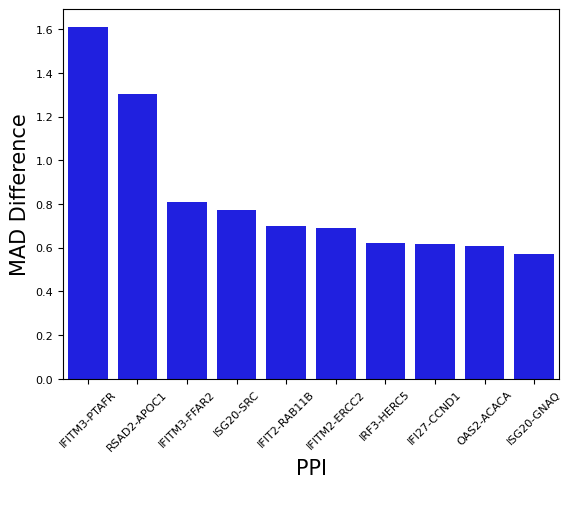

In [381]:


ax= sns.barplot(temp_cd_1_3, x="Interaction", y="diff", color='blue')
temp_cd_1_3_1=temp_cd_1_3[['Interaction','high_light']].drop_duplicates()
plt.xticks(rotation=45,fontsize=8)
for i, tick_label in enumerate(ax.get_xticklabels()):
    if temp_cd_1_3_1['high_light'].values[i]=='yes':
        tick_label.set_color('red')
plt.legend( loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2, borderaxespad=0., fontsize=12, frameon=False, markerscale=5)
plt.xlabel('PPI', fontsize=15)
plt.ylabel('MAD Difference', fontsize=15)
plt.yticks(fontsize=8)
file_name='./fig_6_result/bar_plot/'+query_tp_n+'_'+int_ppi+'.pdf'
#plt.savefig(file_name, format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [382]:
query_tp_n='BP_response_to_type_I_interferon'

In [388]:
os.listdir('./fig_6_result/'+query_tp_n+'/')

['whole_ppi.csv',
 'CD14+ Monocytes_pbmc_ifn.csv',
 'Dendritic cells_pbmc_ifn.csv',
 'CD4 T cells_pbmc_ifn.csv',
 'CD8 T cells_pbmc_ifn.csv',
 'Megakaryocytes_pbmc_ifn.csv',
 'B cells_pbmc_ifn.csv',
 'FCGR3A+ Monocytes_pbmc_ifn.csv',
 'NK cells_pbmc_ifn.csv',
 'whole_ppi_1.csv',
 'CD14+ Monocytes_pbmc_ifn_1.csv',
 'Dendritic cells_pbmc_ifn_1.csv',
 'CD4 T cells_pbmc_ifn_1.csv',
 'CD8 T cells_pbmc_ifn_1.csv',
 'Megakaryocytes_pbmc_ifn_1.csv',
 'B cells_pbmc_ifn_1.csv',
 'FCGR3A+ Monocytes_pbmc_ifn_1.csv',
 'NK cells_pbmc_ifn_1.csv']

In [387]:
cd14=pd.read_csv('./fig_6_result/'+query_tp_n+'/'+CD14+ Monocytes_pbmc_ifn_1.csv')
cd14=cd14[['Interaction','mad']]
cd14.columns=['Interaction','cd14_mad']
cd4=pd.read_csv('./fig_6_result/'+query_tp_n+'/'+'CD8 T cells_pbmc_ifn_1.csv')
cd4=cd4[['Interaction','mad']]
cd4.columns=['Interaction','cd8_mad']

SyntaxError: invalid syntax (3010064910.py, line 1)

In [384]:
cd14=cd14.merge(cd4)
cd14['diff']=abs(cd14['cd14_mad']-cd14['cd8_mad'])
cd14=cd14[cd14['diff']!=0]

In [390]:
cd14[cd14.Interaction.str.contains('IRF7')]

,Interaction,cd14_mad,cd8_mad,diff
530,IKBKE-IRF7,1.048493e-01,1.018862e-01,2.963191e-03
1149,MYD88-IRF7,9.414593e-02,5.182723e-02,4.231870e-02
2682,IRAK1-IRF7,5.523761e-03,5.158124e-03,3.656367e-04
3199,IRF7-TRAF2,1.716360e-02,2.484163e-03,1.467944e-02
3200,IRF7-TRAF6,1.925395e-01,2.003957e-02,1.724999e-01
3201,IRF7-TRIM21,3.757757e-02,3.522255e-02,2.355022e-03
3202,IRF7-TNFAIP3,1.946224e-01,5.167295e-02,1.429494e-01
3203,IRF7-TLK2,3.262251e-02,2.074783e-03,3.054773e-02
3204,IRF7-TICAM1,2.493060e-01,2.380299e-02,2.255030e-01
3205,IRF7-TGFBR1,2.685678e-04,9.046705e-04,6.361027e-04


In [385]:
cd14[(cd14.cd8_mad>cd14.cd14_mad)].sort_values(by='diff').tail(n=20)

,Interaction,cd14_mad,cd8_mad,diff
49,ISG15-GBP1,0.419451,0.478146,0.058695
3126,IFITM2-CDK2,0.033491,0.093214,0.059723
4253,ISG20-EFR3A,0.007278,0.070102,0.062824
1845,HLA-E-FAM189B,0.027274,0.092028,0.064755
2815,CNOT7-GADD45B,0.018237,0.085337,0.067099
1867,PSMB8-USP7,0.055142,0.124717,0.069574
1208,SETD2-TGFBR1,0.030441,0.102540,0.072099
3088,IFIT1-SNRPD3,0.002011,0.076641,0.074630
3114,IFIT1-HNRNPC,0.000433,0.078253,0.077820
838,RSAD2-MMS19,0.098276,0.177898,0.079621


In [391]:
cd14[(cd14.cd8_mad<cd14.cd14_mad)].sort_values(by='diff').tail(n=30)

,Interaction,cd14_mad,cd8_mad,diff
5266,CDC37-IFI35,0.537030,0.203062,0.333968
3653,SHMT2-SAMD9,0.735589,0.387574,0.348015
375,GBP2-GBP1,0.583474,0.234225,0.349248
1030,STAT1-PARP9,0.585902,0.233069,0.352833
4254,ISG20-NCAM1,0.820354,0.448918,0.371436
1756,IRF4-ETV7,0.577586,0.176519,0.401067
3196,IFITM3-RAPGEF3,0.411375,0.002378,0.408997
837,RSAD2-VAPA,0.517119,0.104538,0.412581
4184,OASL-CD14,1.603395,1.171976,0.431419
4273,IRF8-IRF1,0.455435,0.001827,0.453608


In [311]:
cd14[(cd14.cd4_mad<cd14.cd14_mad)].sort_values(by='diff').tail(n=20)

,Interaction,cd14_mad,cd4_mad,diff
3009,IFIT2-HOMER3,0.647779,0.190734,0.457045
5311,BST2-SRC,1.131763,0.673643,0.458120
5442,IRF3-CXCL10,0.815213,0.345050,0.470163
4173,OAS3-CHMP1A,0.517926,0.012760,0.505166
5469,IRF3-HERC5,0.883493,0.373950,0.509543
1650,IRF2-NFKB1,0.516427,0.005299,0.511128
4813,CACTIN-DYNLT1,0.701980,0.169192,0.532788
4079,PTPN11-PILRA,0.552955,0.017716,0.535239
3132,IFITM2-ERCC3,0.616424,0.073164,0.543260
4251,ISG20-GNAQ,1.397352,0.835420,0.561932


In [331]:
cd14[(cd14.cd8_mad>cd14.cd14_mad)].sort_values(by='diff').tail(n=20)

,Interaction,cd14_mad,cd8_mad,diff
15,ADAR-THOC1,0.011730,0.034458,0.022728
810,IFIT2-SNRPB,0.000582,0.023487,0.022905
714,LAMP3-SEC14L1,0.146406,0.172146,0.025740
839,IFIT2-ISG15,0.478571,0.505440,0.026869
915,IFIT3-ISG15,0.571229,0.599000,0.027771
597,EIF2AK2-ISG15,0.295027,0.325236,0.030209
868,IFIT3-SNRPE,0.096915,0.127490,0.030574
964,IFITM3-SNRPD3,0.000937,0.032718,0.031782
831,IFIT2-DBT,0.012433,0.044692,0.032260
719,LAMP3-ATL3,0.002768,0.035877,0.033109


In [216]:
cd14.sort_values(by='diff',ascending=False).head(n=40)

,Interaction,cd14_mad,nk_mad,diff
850,IFIT2-IFIT1,0.094511,0.037183,0.057328
829,IFIT2-IFIT3,0.102422,0.049388,0.053034
875,IFIT3-IFIT2,0.102422,0.049388,0.053034
899,IFIT3-IFIT1,0.085984,0.033892,0.052092
968,IFITM3-CD53,0.072875,0.032798,0.040077
713,LAMP3-RNF213,0.058208,0.023707,0.034502
1004,GAS6-HLA-E,0.056323,0.025946,0.030377
839,IFIT2-ISG15,0.042487,0.015320,0.027167
903,IFIT3-DDX58,0.037966,0.011395,0.026571
824,IFIT2-IFI16,0.044186,0.017869,0.026317
